In [15]:
import sys, os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import seaborn as sb
import torch
import wandb
import yaml
import datetime
from tqdm.notebook import tqdm
import umap
from sklearn.manifold import TSNE
from scipy import stats
from matplotlib.offsetbox import ffsetImage, AnnotationBbox
from sklearn.decomposition import PCA

sys.path.append('../')
from src.dataset_large import ProtoPlanetaryDisks
from src.ae_model_phy import ConvLinTrans_AE
from src.utils import str2bool

main_path = os.path.dirname(os.getcwd())
save_plots = False
%matplotlib inline


In [2]:
ID = '2aqt0sru'
gpu = False
rnd_seed = 13
device = torch.device("cuda:1" if torch.cuda.is_available() and gpu else "cpu")
cmap = 'viridis_r'

## Helping functions

In [3]:
def load_model_list(ID='zg3r4orb', device='cpu'):
    
    fname = glob.glob('%s/wandb/run-*-%s/model.pt' % 
                      (main_path, ID))[0]
    
    config_f = glob.glob('%s/wandb/run-*-%s/config.yaml' % 
                         (main_path, ID))[0]
    with open(config_f, 'r') as f:
        conf = yaml.safe_load(f)
    conf = {k: v['value'] for k,v in conf.items() if 'wandb' not in k}
    aux = re.findall('\/run-(\d+\_\d+?)-\S+\/', config_f)
    conf['date'] = aux[0] if len(aux) != 0 else ''
    del aux
    conf['ID'] = ID
    
    print('Loading from... \n', fname)
    
    model = ConvLinTrans_AE(latent_dim=conf['latent_dim'],
                            img_dim=187,
                            in_ch=1,
                            dropout=conf['dropout'],
                            kernel=conf['kernel_size'],
                            n_conv_blocks=conf['conv_blocks'],
                            phy_dim=conf['physics_dim'],
                            feed_phy=str2bool(conf['feed_phy']))
        
    state_dict = torch.load(fname, map_location=device)
    if list(state_dict.keys())[0].split('.')[0] == 'module':
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
    else:
        new_state_dict = state_dict
    model.load_state_dict(new_state_dict)
    model.eval()
    model.to(device)
    print('Is model in cuda? ', next(model.parameters()).is_cuda)
    
    return model, conf


def evaluate_encoder(model, dataloader, conf, 
                     force=False, device='cpu'):
    
    fname_z = '%s/wandb/run--%s/latent_space_z.txt' % (main_path, conf['ID'])

    if os.path.exists(fname_z) & ~force:
        print('Loading from files...')
        z = np.loadtxt(fname_z)
    
    else:
        print('Evaluating Encoder...')
        time_start = datetime.datetime.now()
        
        z_all, meta, imgs = [], [], []
        with tqdm(total=len(dataloader)) as pbar:
            for i, (img, par) in enumerate(dataloader):
                img = img.to(device)
                par = par.to(device)
                if conf['physics_dim'] > 0:
                    z = model.encode(img, phy=par)
                else:
                    z = model.encode(img)
                z_all.extend(z.data.cpu().numpy())
                meta.append(par.data.cpu().numpy())
                imgs.append(img.data.cpu().numpy())
                torch.cuda.empty_cache()
                pbar.update()

        z_all = np.array(z_all)
        meta = np.concatenate(meta, axis=0)
        imgs = np.concatenate(imgs, axis=0)

        #np.savetxt(fname_mu, mu)
        #np.savetxt(fname_std, std)
        #np.savetxt(fname_lbs, np.asarray(labels), fmt='%s')
        elap_time = datetime.datetime.now() - time_start
        print('Elapsed time  : %.2f s' % (elap_time.seconds))
        print('##'*20)
        
    z_df = pd.DataFrame(z_all)
    
    return z_df, meta, imgs


def give_me_latent(ID='4kb62bfn', device='cpu', rnd_seed=rnd_seed, force=True):
    
    ## Download run files from WB
    if not os.path.exists('%s/wandb/run--%s/model.pt' % 
                      (main_path, ID)):
        print('Downloading files from Weight & Biases')
    
        api = wandb.Api()
        run = api.run('deep_ppd/PPD-AE/%s' % (ID))
        run.file('model.pt').download(replace=True, 
                                  root='%s/wandb/run--%s/' % 
                                  (main_path, ID))
        run.file('config.yaml').download(replace=True, 
                                     root='%s/wandb/run--%s/' % 
                                     (main_path, ID))
    
    ## load model and params
    model, config = load_model_list(ID=ID, device=device)
    for key, value in config.items():
        print('%15s\t: %s' % (key, value))
    
    ## load data and data loaders
    dataset = ProtoPlanetaryDisks(machine='exalearn', 
                                  transform=False, 
                                  par_norm=True)
    train_loader, val_loader, test_loader = dataset.get_dataloader(batch_size=128,
                                                               shuffle=True,
                                                               val_split=.2,
                                                               random_seed=rnd_seed)
    
    ## evaluate encoder and save latent code
    z, pp, imgs = evaluate_encoder(model, val_loader, config, 
                                   force=force, device=device)
    if config['par_norm'] == 'T':
        pp = dataset.MinMaxSc.inverse_transform(pp)
    
    return z, pp, imgs, dataset, model

In [4]:
def scatter_hue(x, y, labels, disc=True, c_label='', norm=None):
    """Creates a wall of light curves plot with real and reconstruction
    sequences, paper-ready.
    Parameters
    ----------
    x      : array
        data to be plotted in horizontal axis
    y      : array
        data to be plotted in vertical axis
    labels : list, optional
        list with corresponding lables to be displayed as legends
    disc : bool, optional
        wheather the axis used for coloring is discrete or not
    c_label    : bool, optional
        name of color dimension
        
    Returns
    -------
        display figure
    """
    
    fig = plt.figure(figsize=(12,9))
    if disc:
        c = cm.Dark2_r(np.linspace(0,1,len(set(labels))))
        for i, cls in enumerate(set(labels)):
            idx = np.where(labels == cls)[0]
            plt.scatter(x[idx], y[idx], marker='.', s=20,
                        color=c[i], alpha=.7, label=cls)
    else:
        plt.scatter(x, y, marker='.', s=20,
                    c=labels, cmap=cmap, alpha=.7,
                    norm=norm)
        cbar = plt.colorbar()
        cbar.set_label(label=c_label, fontsize=20)
        
    plt.xlabel('embedding 1')
    plt.ylabel('embedding 2')
    plt.legend(loc='best', fontsize='x-large')
    plt.show()

    
def corr_heatmap(corr, ylab='z', xlab='z', name=''):
    fig = plt.figure(figsize=(8,8))
    plt.title(name)
    ax = sb.heatmap(corr, vmin=-1, vmax=1, center=0, 
                    cmap=sb.diverging_palette(20, 220, n=200),
                    annot=True, fmt='0.3f')
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right')
    ax.set_yticklabels(
        np.arange(corr.shape[0]),
        rotation=45,
        horizontalalignment='right')
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    #plt.savefig('%s/imgs/%s.pdf' % (dpath, name), 
    #            format='pdf', bbox_inches='tight')
    plt.show()
    return

def latent_space_jointdist(z, pp, par_names=''):
    for k, par in enumerate(dataset.par_names):
        if par in ['m_dust', 'a_max']:
            label = 'log(%s)' % (par)
            norm = colors.LogNorm()
        else:
            label = par
            norm = None
        
        g = sb.PairGrid(z, corner=False, despine=True)
        g = g.map_diag(plt.hist, histtype='step', lw=1.5)
        g = g.map_offdiag(plt.scatter, marker='.', s=30, alpha=.4, edgecolors='none', 
                          color=None, c=pp[:,k], cmap=cmap, norm=norm)
        cbar = plt.colorbar(shrink=5, fraction=.8, ax=g.axes[3,6], drawedges=False)
        for i, j in zip(*np.triu_indices_from(g.axes, 1)):
            g.axes[i, j].set_visible(False)
        g = g.add_legend(loc='upper center', fontsize=20, title='', 
                             markerscale=4, ncol=2)
        cbar.set_label(label, fontsize=20)
        for ax in g.axes.flat:
            # This only works for the left ylabels
            ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
            ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        
        #if save_plots:
        #    plt.savefig('%s/imgs/z_pairplot_%s.pdf' % (path,ID), 
        #            format='pdf', bbox_inches='tight')
            
        plt.show()

    #break
    
def tsne_projection(z, pp, par_names='', per=40):
    tsne = TSNE(n_components=2, perplexity=per, 
            random_state=10, verbose=0, learning_rate=20)
    z_tsne = tsne.fit_transform(z.values)
    
    for k, par in enumerate(par_names):
        if par in ['m_dust', 'a_max']:
            label = 'log(%s)' % (par)
            norm = colors.LogNorm()
        else:
            label = par
            norm = None
        scatter_hue(z_tsne[:,0], z_tsne[:,1], 
                    pp[:,k], disc=False, c_label=label,
                    norm=norm)
    return z_tsne

    
def umap_projection(z, pp, par_names='', nn=30, md=.12):
    umapper = umap.UMAP(n_neighbors=nn, min_dist=md, 
                    n_components=2, metric='euclidean')
    z_umap = umapper.fit_transform(z.values)
    
    for k, par in enumerate(dataset.par_names):
        if par in ['m_dust', 'a_max']:
            label = 'log(%s)' % (par)
            norm = colors.LogNorm()
        else:
            label = par
            norm = None
        scatter_hue(z_umap[:,0], z_umap[:,1], 
                    pp[:,k], disc=False, c_label=label,
                    norm=norm)
    return z_umap

def pca_projection(z, pp, par_names=''):
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z)
    
    for k, par in enumerate(dataset.par_names):
        if par in ['m_dust', 'a_max']:
            label = 'log(%s)' % (par)
            norm = colors.LogNorm()
        else:
            label = par
            norm = None
        scatter_hue(z_pca[:,0], z_pca[:,1], 
                    pp[:,k], disc=False, c_label=label,
                    norm=norm)
    return z_pca
    
        
def calculate_corr(latent, meta, phys_names=[]):
    corr_heatmap(latent.corr(method='spearman'), 
                 name='spearman autocorr')
    latent = latent.values
    
    spearman = pd.DataFrame(columns=phys_names, 
                            index=range(latent.shape[1]), 
                            dtype=np.float32)
    spearman_p = pd.DataFrame(columns=phys_names, 
                            index=range(latent.shape[1]), 
                            dtype=np.float32)
    pearson = pd.DataFrame(columns=phys_names, 
                           index=range(latent.shape[1]), 
                           dtype=np.float32)
    pearson_p = pd.DataFrame(columns=phys_names, 
                           index=range(latent.shape[1]), 
                           dtype=np.float32)

    for i, phy in enumerate(phys_names):
        for k in range(latent.shape[1]):
            #print('Latent Dim: ', k)
            pcorr, pp_val = stats.pearsonr(meta[:,i], latent[:,k])
            pearson.loc[k,phy] = pcorr
            pearson_p.loc[k,phy] = pp_val
            scorr, sp_val = stats.spearmanr(meta[:,i], latent[:,k])
            spearman.loc[k,phy] = scorr
            spearman_p.loc[k,phy] = sp_val
            
    corr_heatmap(spearman, xlab='', name='spearman pairwise corr coef')
    corr_heatmap(spearman_p, xlab='', name='pearson pairwise corr coef p-vals')
            
    return spearman, spearman_p, pearson, pearson_p

def plot_scatter_stamps(xy, stamps, N=100, name='', 
                        xlim=None, ylim=None):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(xy[:,0], xy[:,1], marker='.', s=10,
               alpha=.3)
    for i, idx in enumerate(np.random.choice(xy.shape[0], N)):
        imagebox = OffsetImage(stamps[idx, 0,:,:], zoom=.12, 
                               cmap='viridis', norm=None)
        ab = AnnotationBbox(imagebox, (xy[idx]), frameon=False)
        ax.add_artist(ab)
    if xlim and ylim:
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.xlabel('embedding 1')
    plt.ylabel('embedding 2')
    plt.title(name)
    plt.draw()
    plt.show()

# Return latent codes

In [6]:
z, pp, imgs, dataset, model = give_me_latent(ID=ID, device=device)

Loading from... 
 /home/jorgemarpa/Astro/PPDAE/wandb/run--2aqt0sru/model.pt
Is model in cuda?  False
     batch_size	: 128
        comment	: 
           cond	: T
    conv_blocks	: 4
           data	: PPD
        dropout	: 0.2
        dry_run	: False
     early_stop	: False
       feed_phy	: F
       img_norm	: T
    kernel_size	: 3
     latent_dim	: 8
             lr	: 0.0005
         lr_sch	: step
        machine	: exalearn
     model_name	: ConvLinTrans_AE
 n_train_params	: 4614627
     num_epochs	: 100
       par_norm	: T
    physics_dim	: 8
       rnd_seed	: 13
           date	: 
             ID	: 2aqt0sru
Evaluating Encoder...



Elapsed time  : 218.00 s
########################################


### Latent space joint dist

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f8568f799a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


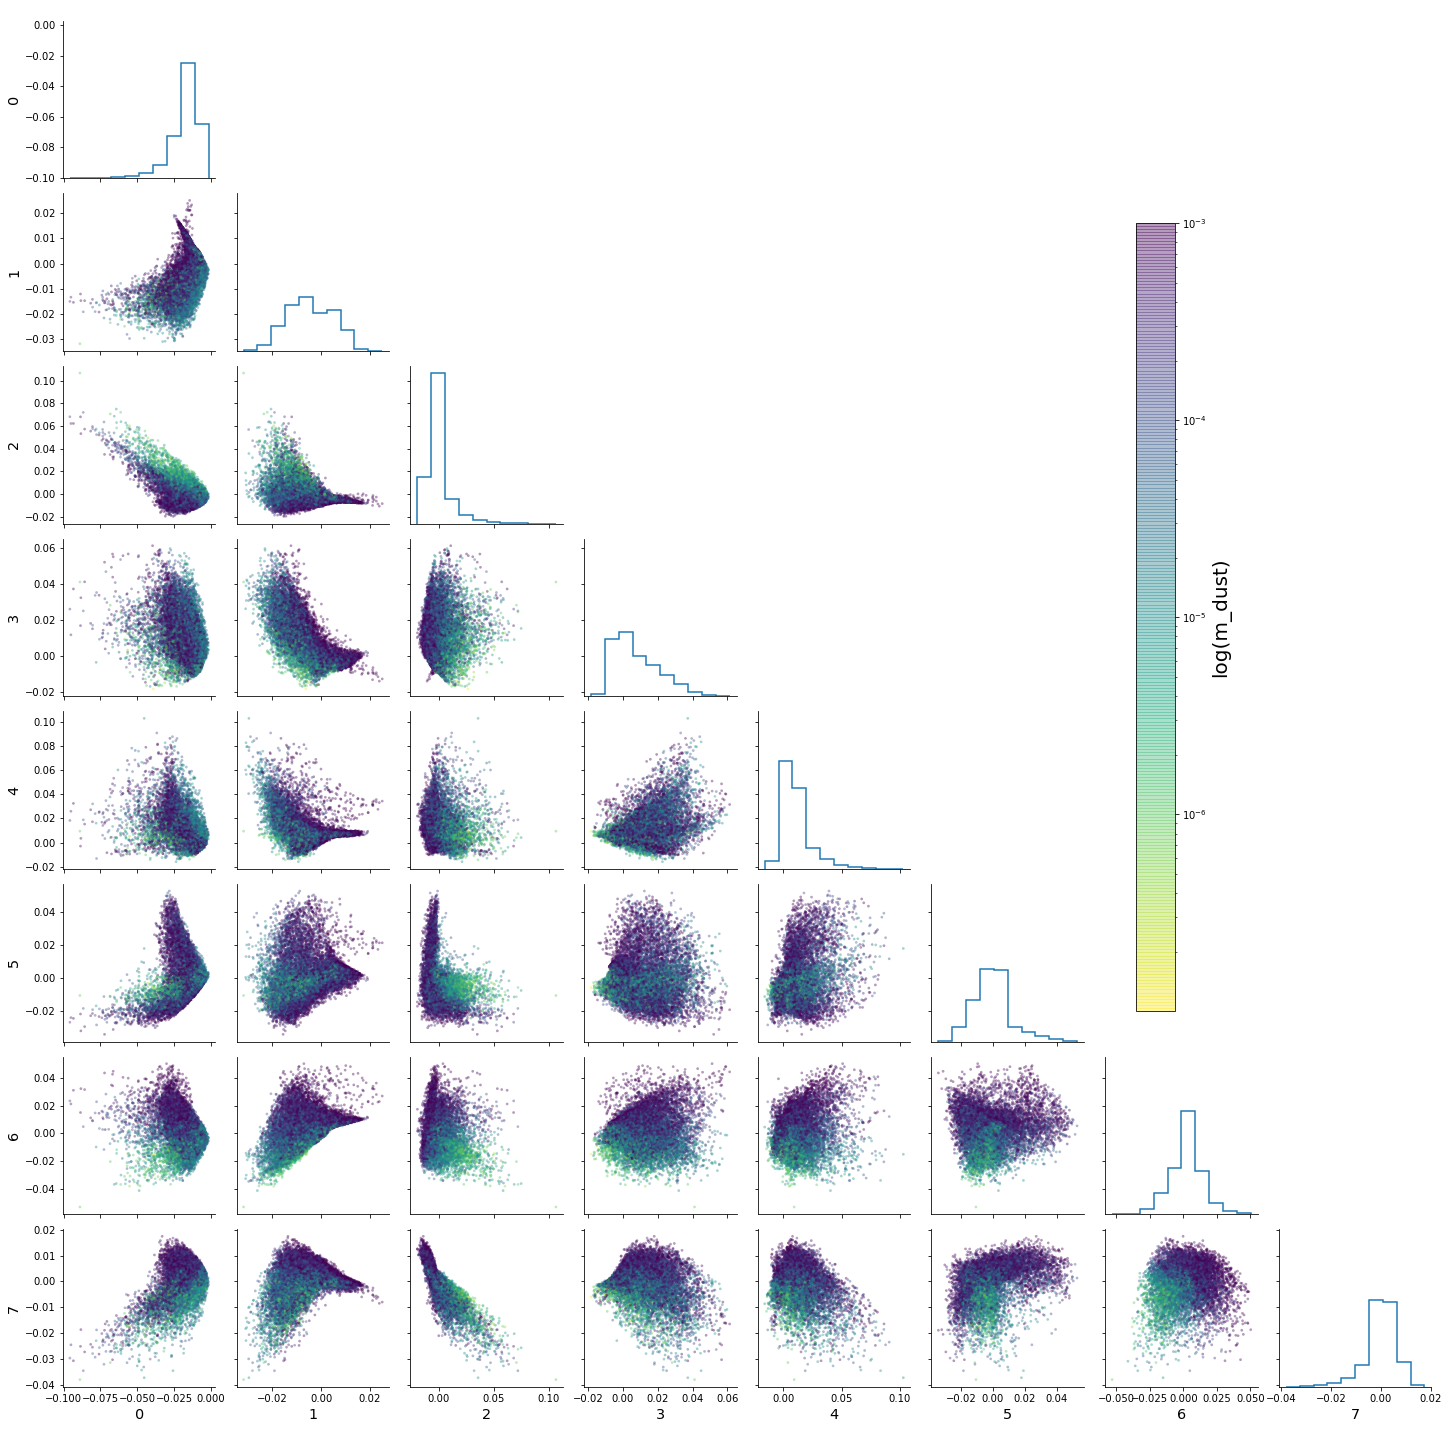

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f8561d8b730> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


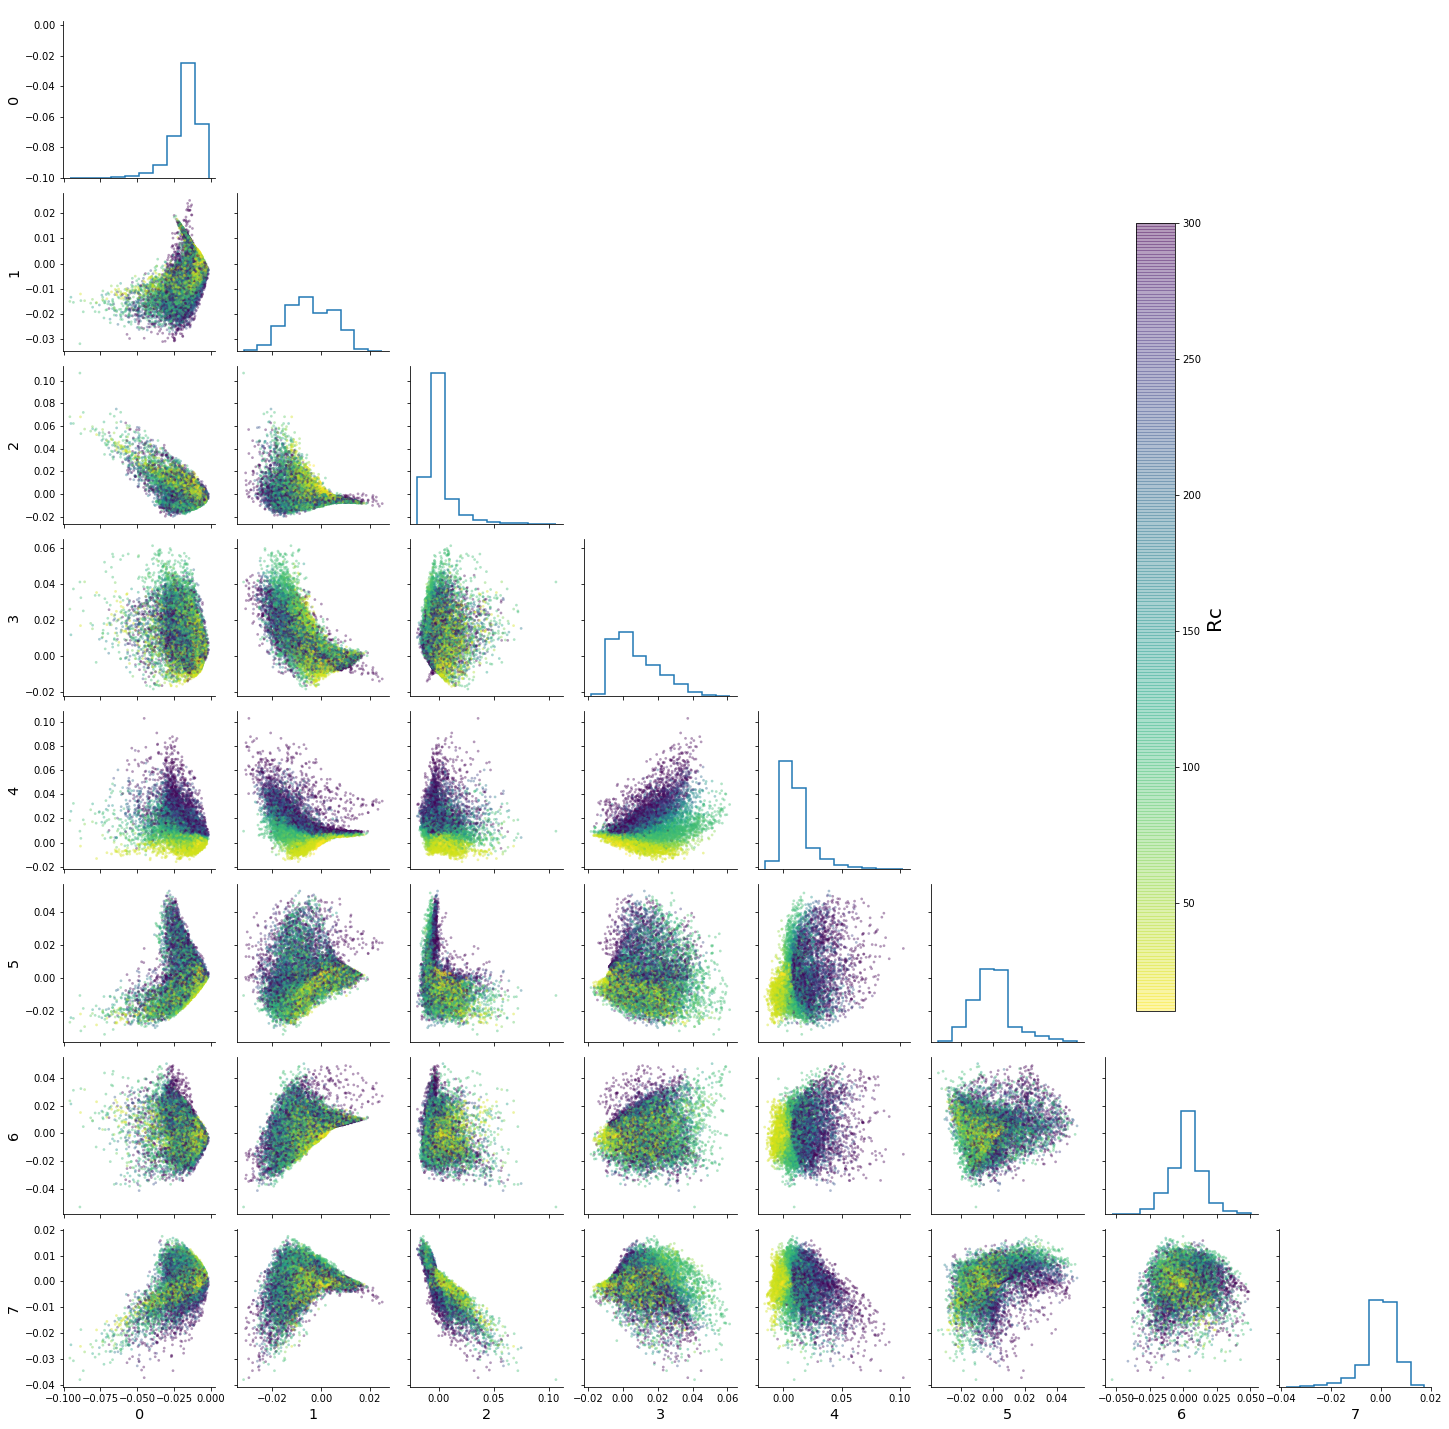

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f8562ee99a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


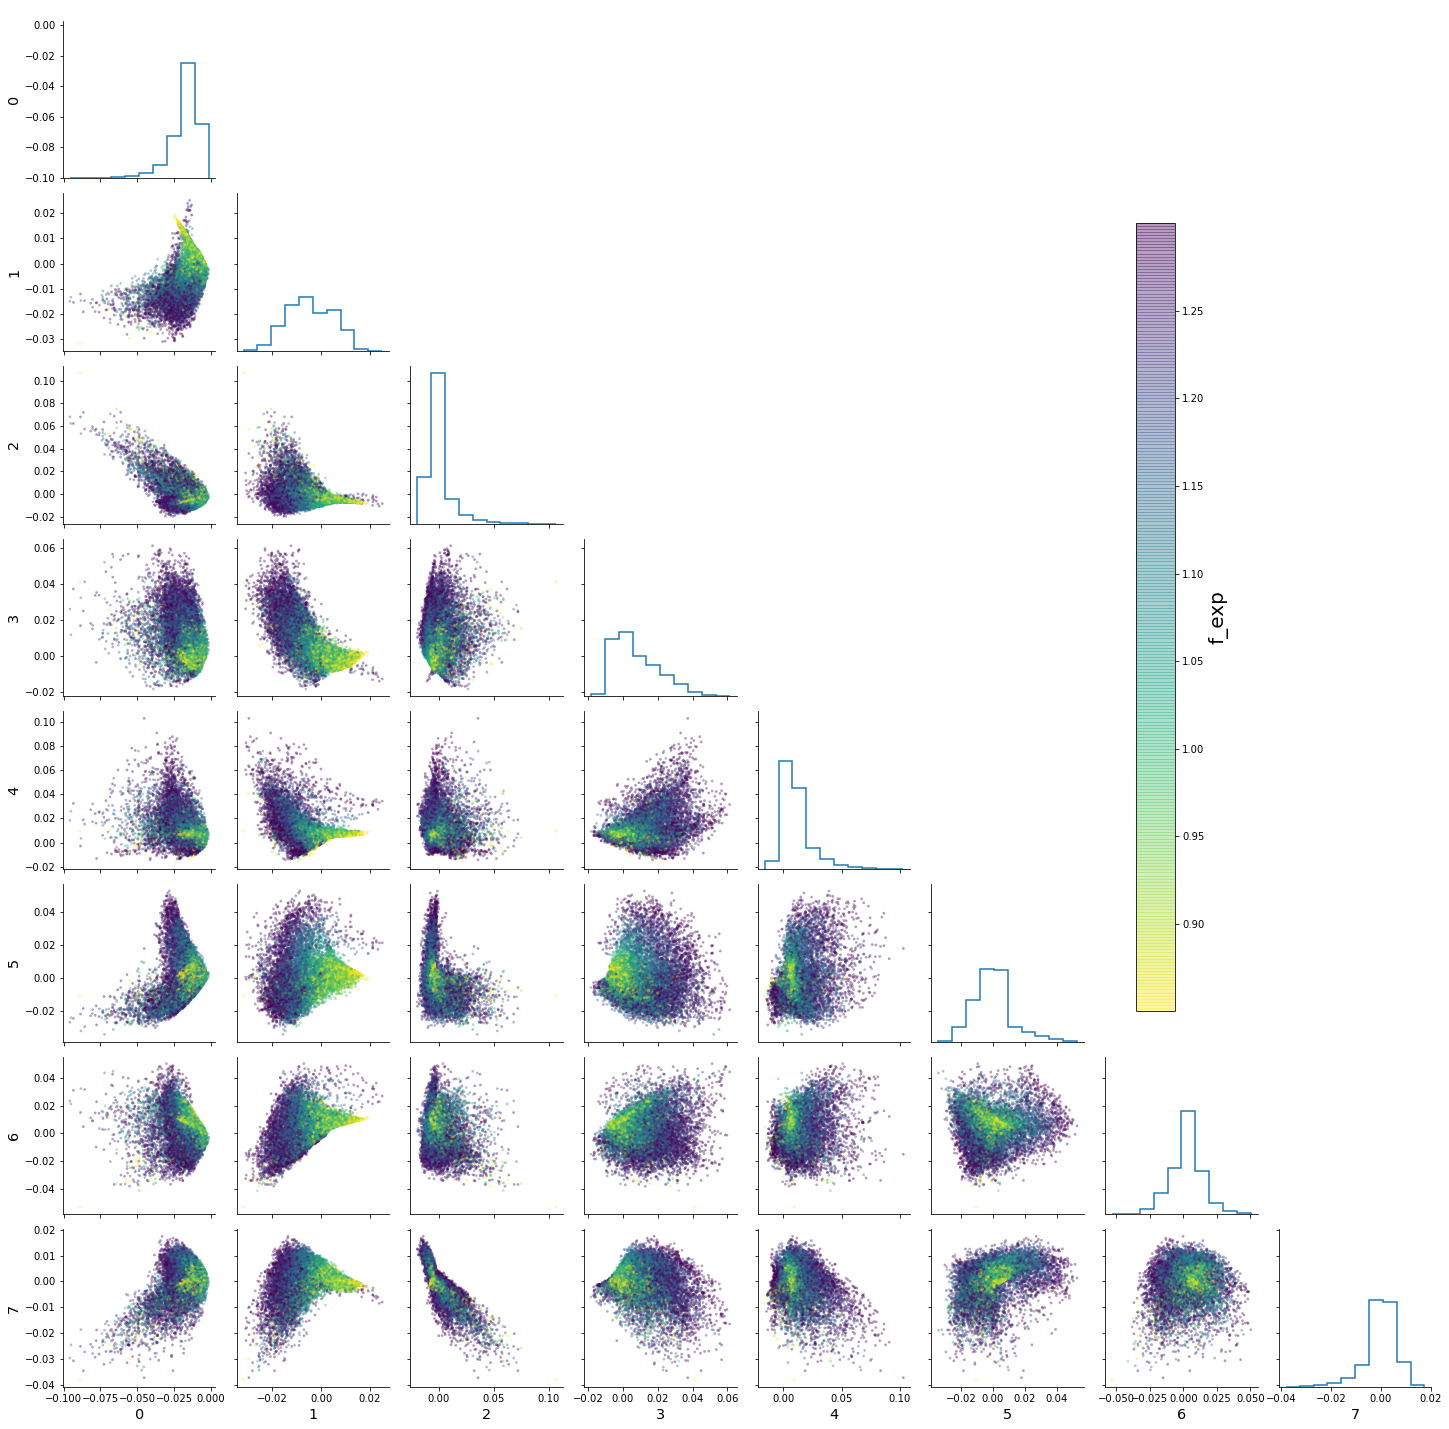

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f8561ea62b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


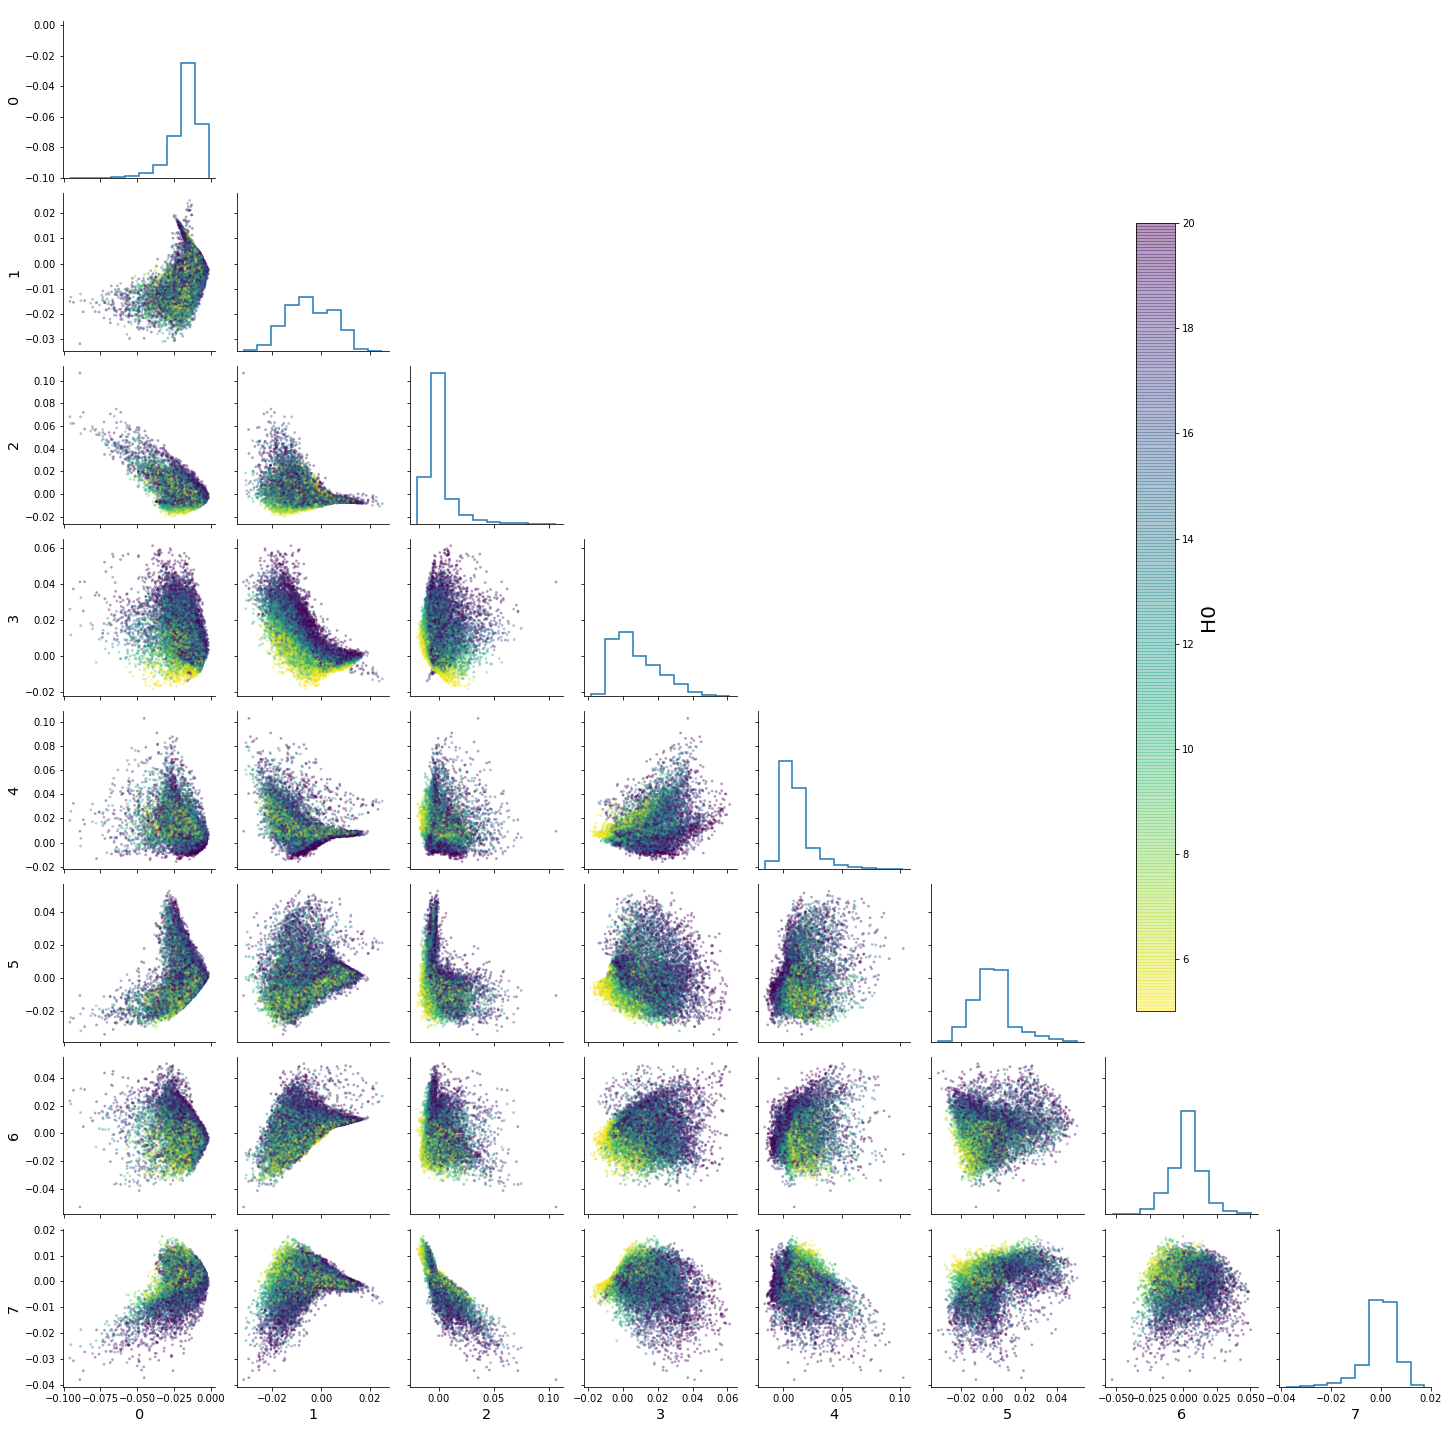

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f85620fb400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


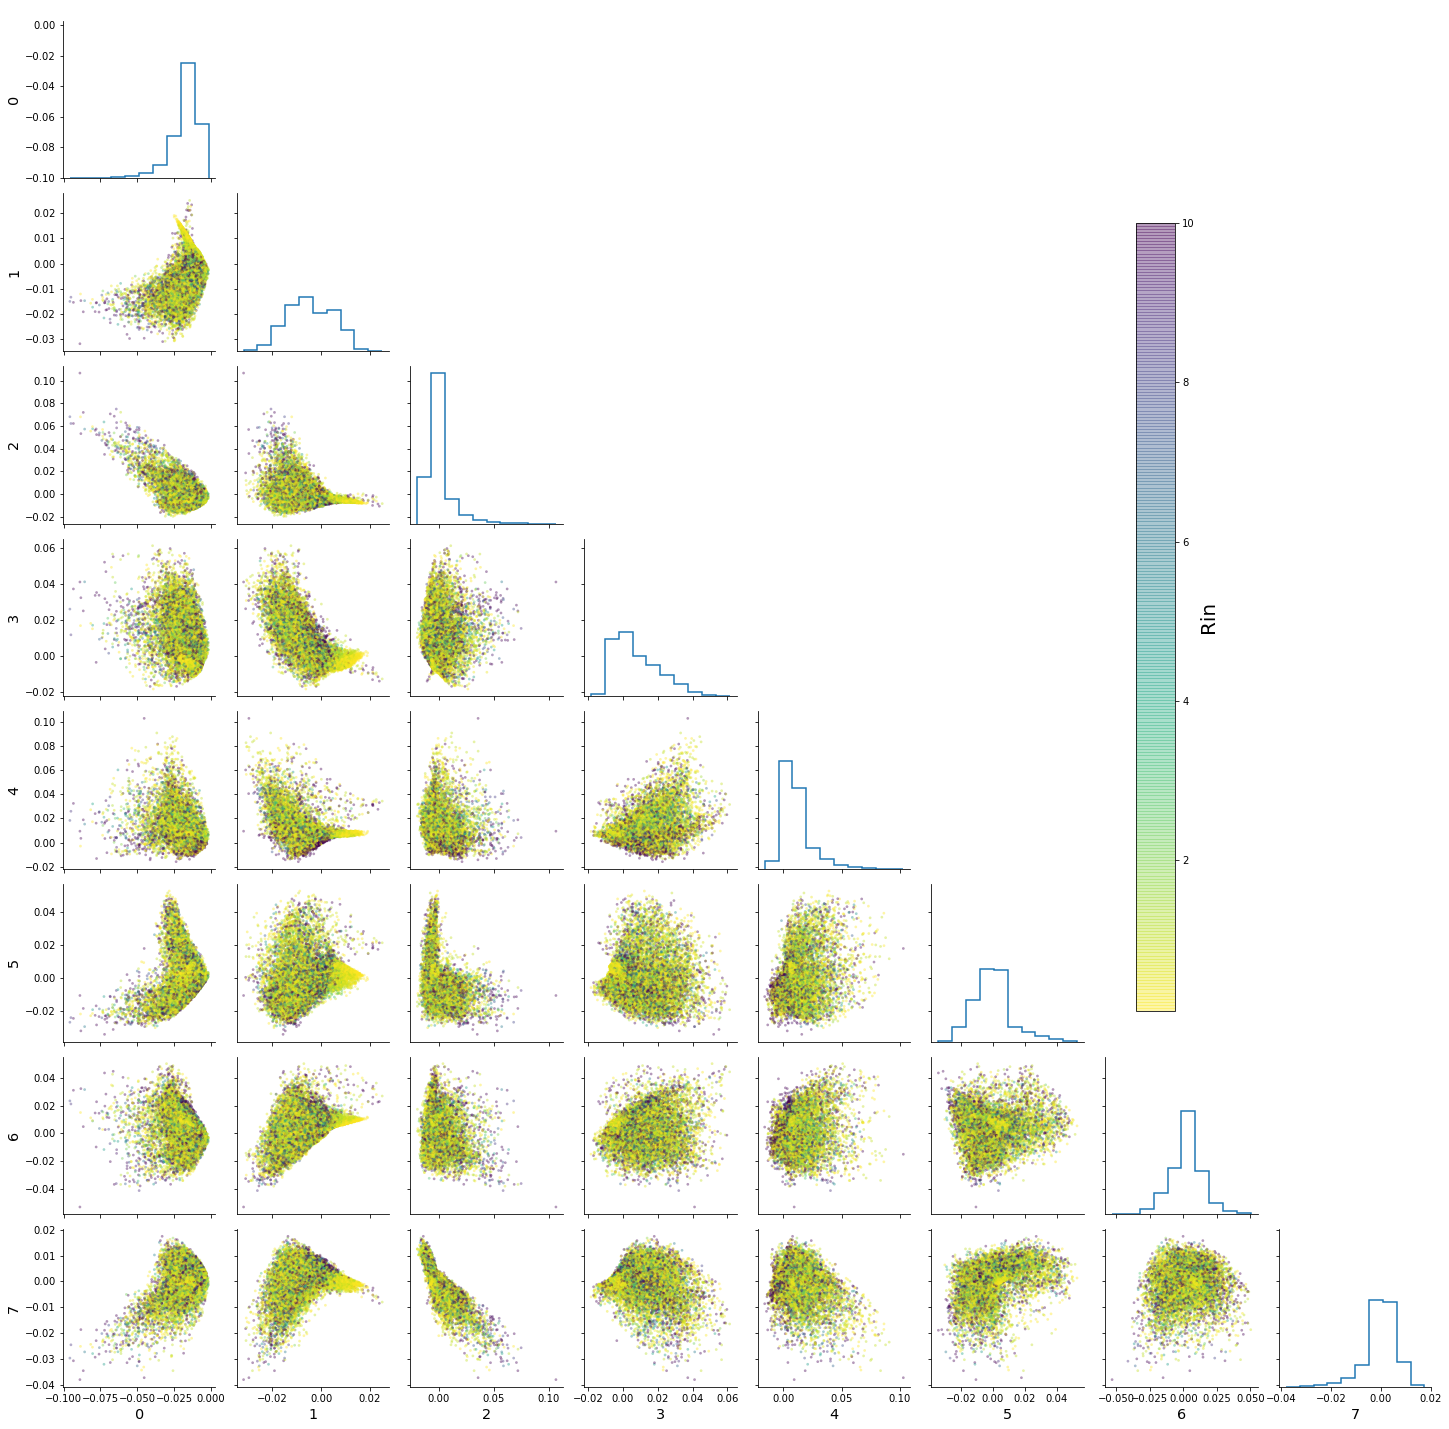

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f85776c21f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


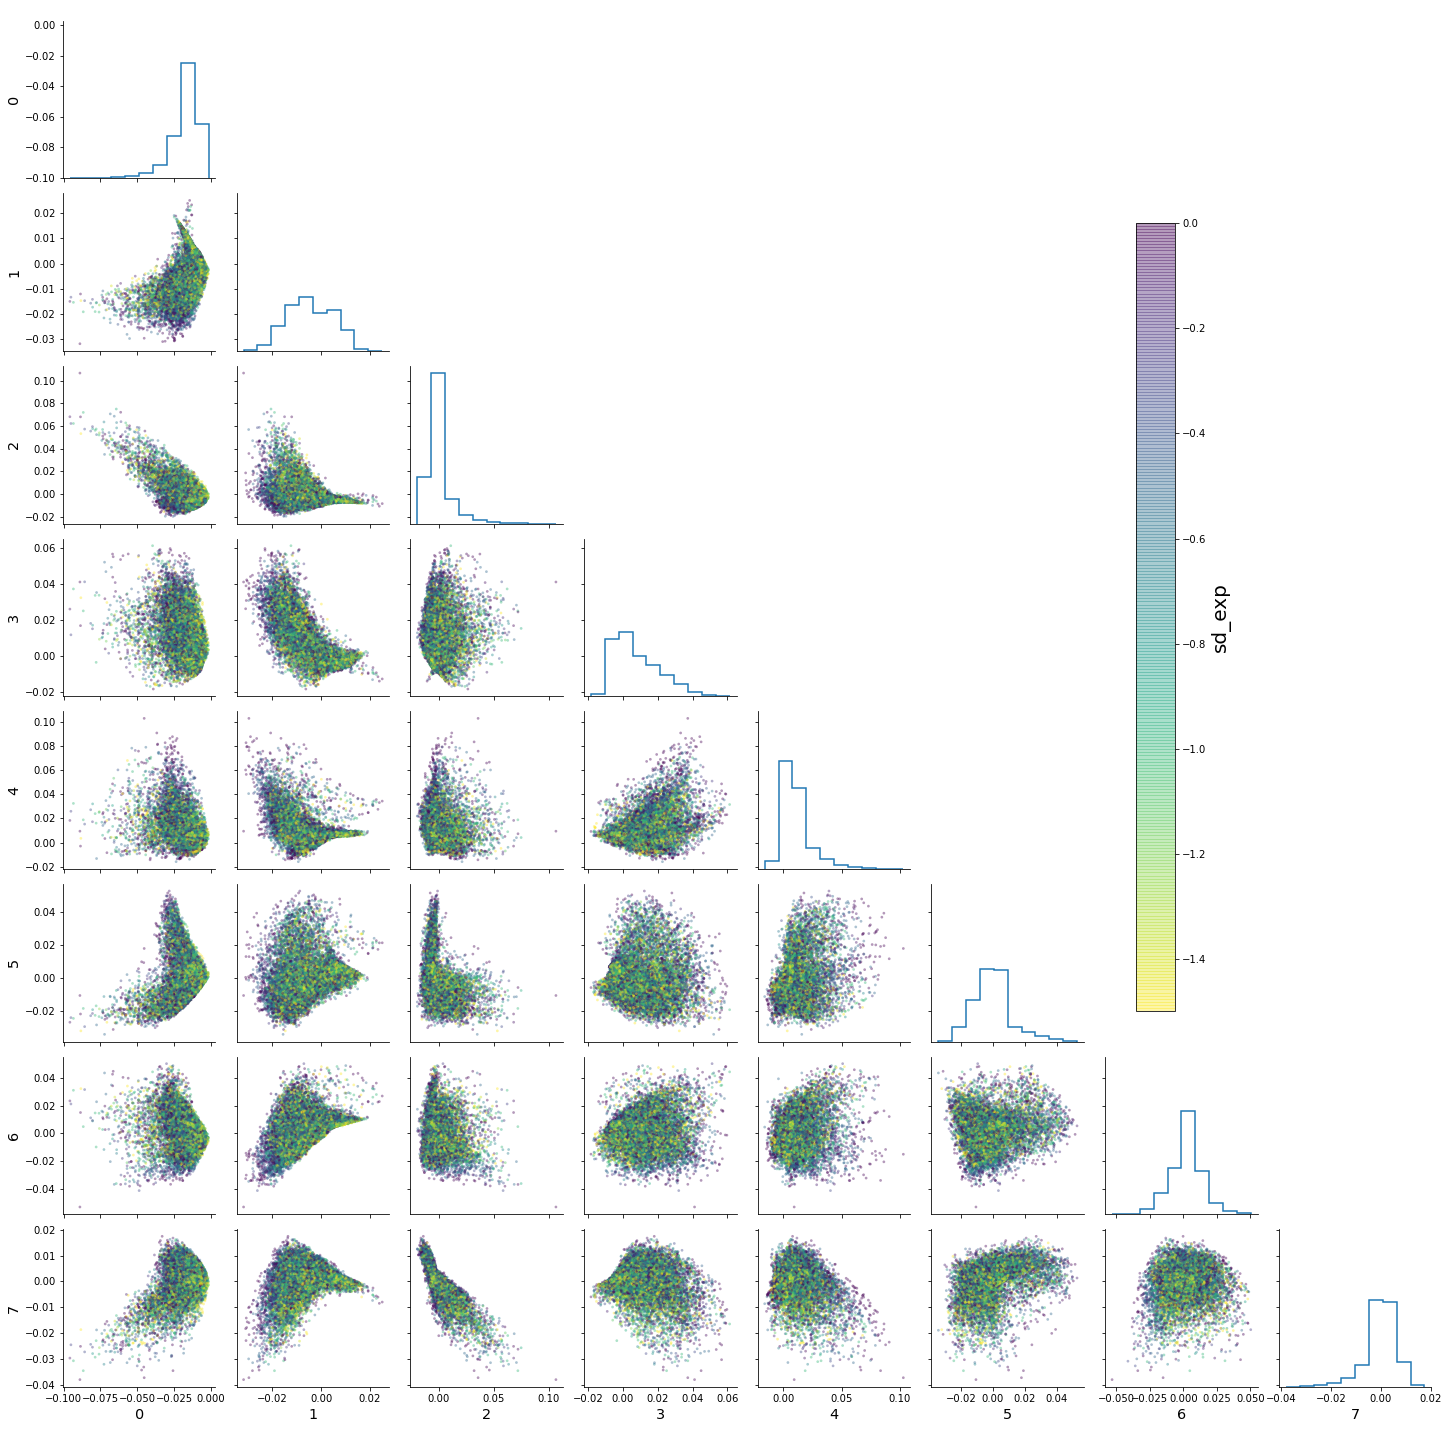

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f85627e60d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


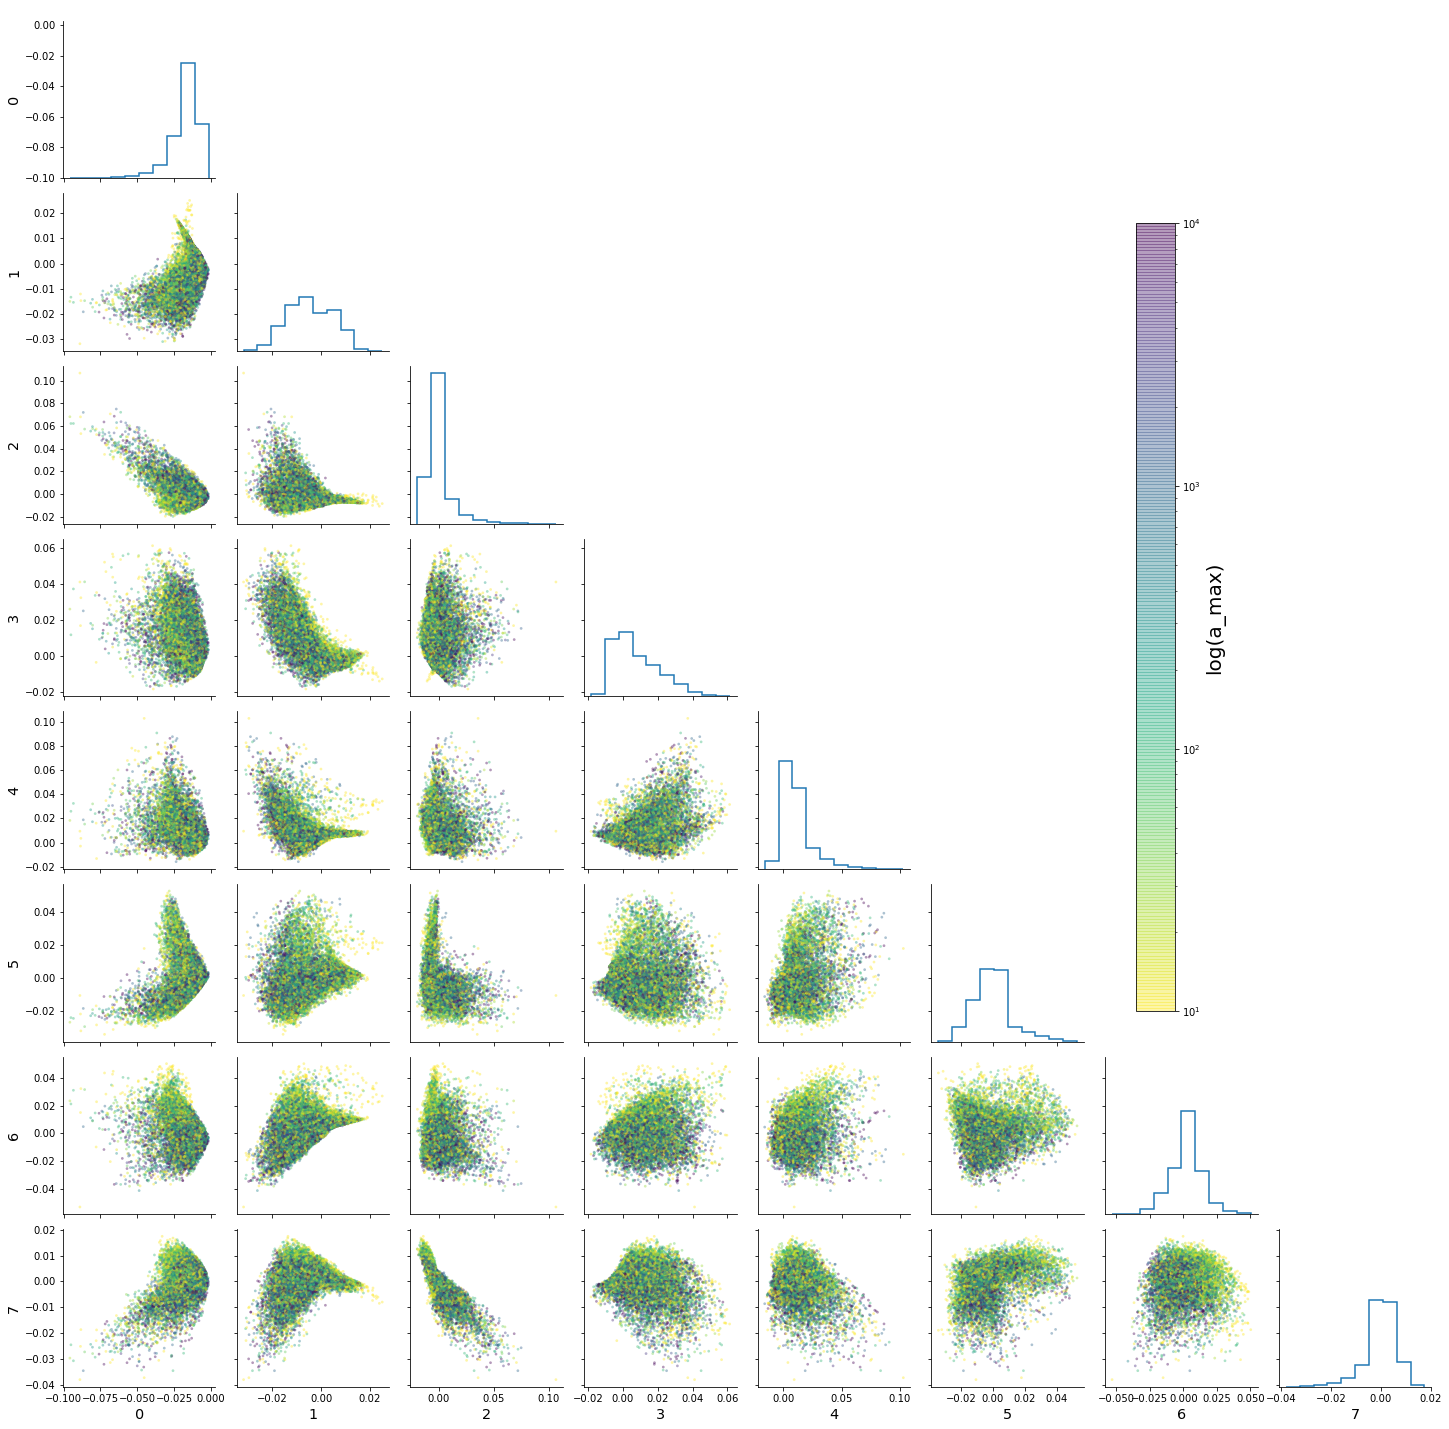

/home/jorgemarpa/anaconda3/envs/torch1.6/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f856e02c8b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


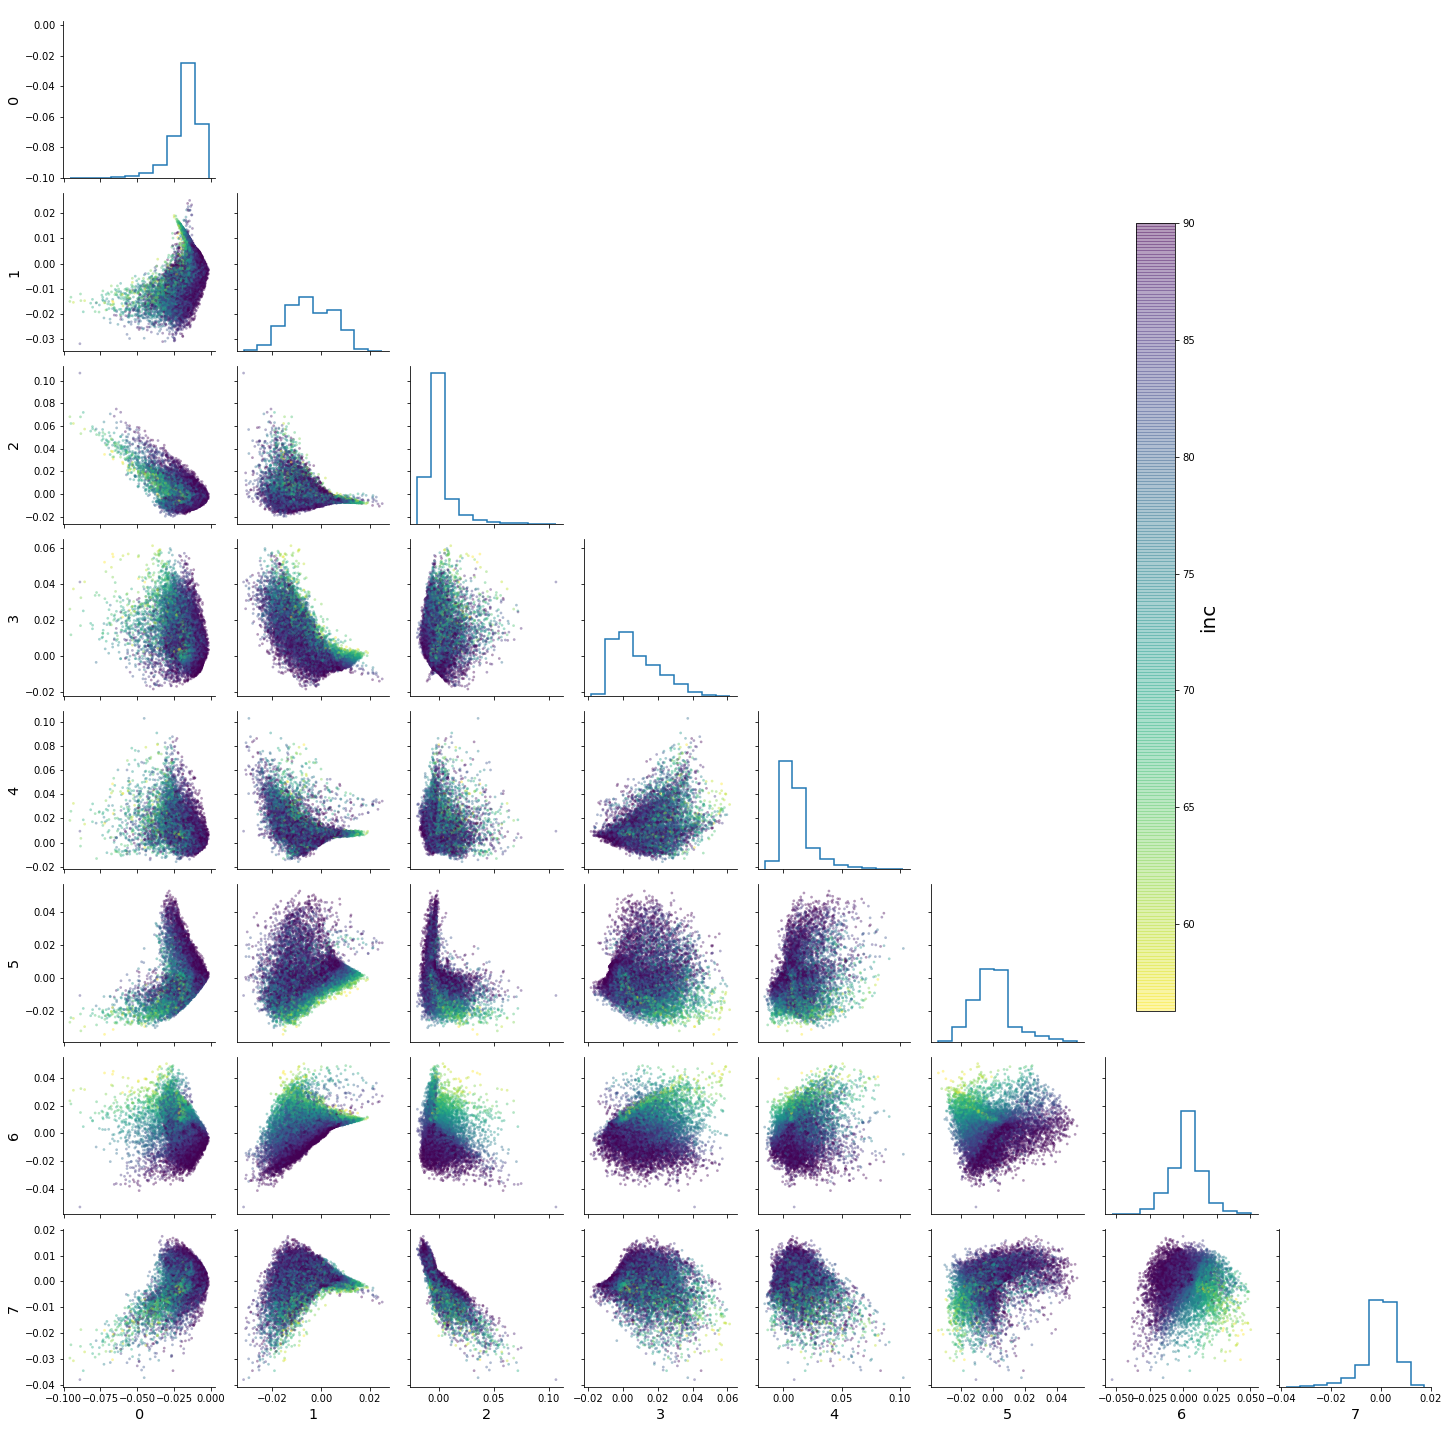

In [8]:
latent_space_jointdist(z, pp, par_names=dataset.par_names)

### tSNE projection to 2D

In [7]:
z_tsne = tsne_projection(z, pp, par_names=dataset.par_names, per=20)

No handles with labels found to put in legend.
<ipython-input-4-715b791a5d1f>:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


### UMAP

In [8]:
z_umap = umap_projection(z, pp, par_names=dataset.par_names, nn=50, md=0.1)

No handles with labels found to put in legend.
<ipython-input-4-715b791a5d1f>:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-4-715b791a5d1f>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,9))
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


### PCA

In [9]:
z_pca = pca_projection(z, pp, par_names=dataset.par_names)

No handles with labels found to put in legend.
<ipython-input-4-715b791a5d1f>:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


### Correlation between Phys-Latent space

In [10]:
sp, sp_pval, pe, pe_pval = calculate_corr(z, pp, phys_names=dataset.par_names)

<ipython-input-4-715b791a5d1f>:60: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## 2D projection with stamps

In [11]:
plot_scatter_stamps(z_umap, imgs, N=100, name='UMAP')
plot_scatter_stamps(z_tsne, imgs, N=100, name='t-SNE')

<ipython-input-4-715b791a5d1f>:197: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [12]:
plot_scatter_stamps(z_pca, imgs, N=100, name='PCA', 
                    xlim=(np.percentile(z_pca[:,0], 1), 
                          np.percentile(z_pca[:,0], 99)), 
                    ylim=(np.percentile(z_pca[:,1], 1), 
                          np.percentile(z_pca[:,1], 99)))

<ipython-input-4-715b791a5d1f>:197: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Save to html file 

In [63]:
out_name = 'latent_explorer_%s.html' % (ID)
!jupyter nbconvert --to html latent_explorer.ipynb --output $out_name

[NbConvertApp] Converting notebook latent_explorer.ipynb to html
[NbConvertApp] Writing 17376655 bytes to latent_explorer_ogqofvbf_fexp1.html


In [ ]:
d